In [24]:
import h5py
from pymoo.indicators.hv import HV
from core.learners.metrics import non_dominated, non_dominated_rank, crowding_distance, compute_hypervolume
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
logdir = "runs/2024-06-14_07-49-45_c519/log.h5"
objectives = []
to_check = []
with h5py.File(logdir, "r") as f:
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    
    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key]))
    
    # If a_group_key is a group name,
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])
    print(list(f[list(f.keys())[1]]))
    params = f["params"]
    
    print("Iterations: \t", params["iterations"][0][1])
    print("N_populations: \t", params["n_population"][0][1])
    print("Parallel: \t", params["parallel"][0][1])
    
    group = f["train"]
    objectives = group["returns"]["ndarray"][:]
    to_check = non_dominated(group["returns"]["ndarray"][-1])
    print(objectives)
    
    print(non_dominated(group["returns"]["ndarray"][-1]))
    # # print("Hypervolume:", group['hypervolume'][()])
    # # print("Indicator metric:", group['metric'][()])
    # print("ND returns:", non_dominated(group["returns"]["ndarray"][-1]))
    # # print(group['returns']['step'][()])
    # print("Training took", group["time"][0][1], "seconds")
    # print(group["hypervolume"][0])
    # plt.plot(group["hypervolume"][()][:, 0], group["hypervolume"][()][:, 1], marker=".")
    # plt.show()

Keys: <KeysViewHDF5 ['params', 'train']>
<class 'h5py._hl.group.Group'>
['hypervolume', 'metric', 'returns', 'time']
Iterations: 	 200.0
N_populations: 	 128.0
Parallel: 	 1.0
[[[ 1.01867743e+01 -9.13193077e-03 -1.87165484e-01  1.00000000e+00]
  [ 1.01461363e+01 -9.70140286e-03 -1.88045487e-01  1.00000000e+00]
  [ 9.67559052e+00 -2.10053138e-02 -1.95747256e-01  1.00000000e+00]
  ...
  [ 9.99539280e+00 -6.26114290e-03 -1.78419024e-01  1.00000000e+00]
  [ 9.04924202e+00 -3.37752588e-02 -2.01032475e-01  1.00000000e+00]
  [ 8.82141018e+00 -3.75100709e-02 -2.07533509e-01  1.00000000e+00]]

 [[ 1.12314692e+01 -1.07142015e-03 -1.92759126e-01  1.00000000e+00]
  [ 1.00821829e+01 -1.22124869e-02 -1.93681881e-01  1.00000000e+00]
  [ 9.88634014e+00 -1.37440832e-02 -1.92262828e-01  1.00000000e+00]
  ...
  [ 9.47545242e+00 -2.10264567e-02 -1.84646949e-01  1.00000000e+00]
  [ 9.48837566e+00 -1.68805607e-02 -1.79537311e-01  1.00000000e+00]
  [ 9.61970234e+00 -1.16068739e-02 -1.80746943e-01  1.00000000

In [26]:
def indicator_hypervolume(points, ref, nd_penalty=0.0):
    # compute hypervolume of dataset
    nd_i = non_dominated(points, return_indexes=True)[1]
    nd = points[nd_i]
    hv = compute_hypervolume(nd, ref)
    # hypervolume without a point from dataset
    hv_p = np.zeros(len(points))
    # penalization if point is dominated
    is_nd = np.zeros(len(points), dtype=bool)
    for i in range(len(points)):
        is_nd[i] = np.any(np.all(nd == points[i], axis=1))
        if is_nd[i]:
            # if there is only one non-dominated point, and this point is non-dominated,
            # then it amounts for the full hypervolume
            if len(nd) == 1:
                hv_p[i] = 0.0
            else:
                # remove point from nondominated points, compute hv
                rows = np.all(nd == points[i], axis=1)
                hv_p[i] = compute_hypervolume(nd[np.logical_not(rows)], ref)
        # if point is dominated, no impact on hypervolume
        else:
            hv_p[i] = hv

    indicator = hv - hv_p - nd_penalty * np.logical_not(is_nd)
    return indicator

In [27]:
def get_hvs(objectives, best, worst):
    hv = HV(ref_point=np.array([1.2, 1.2, 1.2, 1.2]))  # Reference set, works fine since everything is btwn 0-1
    hvs = np.empty(0)
    for objective in objectives:
        hvs = np.append(
                hvs,
                (
                    hv.do(
                        normalize_objs(  # Read and normalize data frames with 5 objectives
                            objective,
                            worst,
                            best,
                        )
                    )
                ),
            )
    return hvs

In [28]:
def normalize_objs(df, worst, best):
    return (best - df) / (best - worst)

In [29]:
transformation_vector = np.array([1, -1, -1, 1])
transformed_objectives = np.empty_like(objectives)
for i in range(objectives.shape[0]):
    for j in range(objectives.shape[1]):
        transformed_objectives[i, j] = objectives[i, j] * transformation_vector
        transformed_objectives[i, j, 3] = 1 - transformed_objectives[i, j, 3]
       
nd = []
for i in range(len(objectives)):
    nd.append(non_dominated(transformed_objectives[i]))

In [30]:
min_values = np.zeros(4)
max_values = np.zeros(4)

for channel in range(4):
  # Update min and max values for the current channel
  min_values[channel] = np.min(transformed_objectives[:, :, channel])
  max_values[channel] = np.max(transformed_objectives[:, :, channel])

# Print the results
print("Minimum values:", min_values)
print("Maximum values:", max_values)

Minimum values: [ 7.84950495 -0.          0.11742073  0.        ]
Maximum values: [1.33837137e+01 3.99541482e-02 2.35401317e-01 4.16666269e-03]


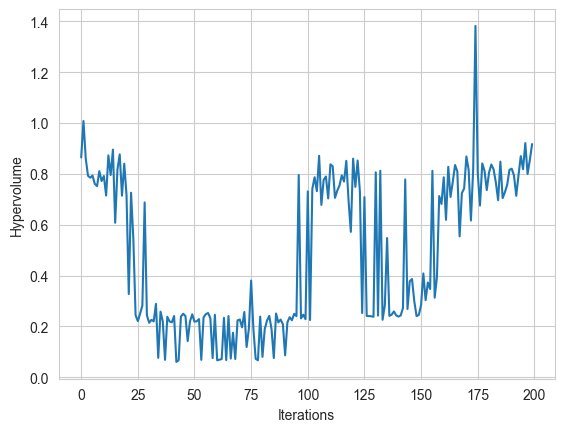

In [32]:
hvs = get_hvs(nd, min_values, max_values)

plt.plot(hvs)
plt.xlabel("Iterations")
plt.ylabel("Hypervolume")
plt.savefig("convergence_mones.svg", bbox_inches="tight")
plt.show()

In [9]:
reshaped_obj = objectives.reshape(-1, 4)
nds_overall = non_dominated(reshaped_obj)
to_check *= [1, -1, -1, 1]
for i in range(len(to_check)):
    to_check[i][3] = 1 - to_check[i][3]
print(get_hvs([to_check], min_values, max_values)[0])

0.8241088905195529


In [10]:
to_check

array([[ 1.26284580e+01, -0.00000000e+00,  2.10277051e-01,
         0.00000000e+00],
       [ 1.24796238e+01, -0.00000000e+00,  1.97441846e-01,
         0.00000000e+00],
       [ 1.23796158e+01, -0.00000000e+00,  1.94705963e-01,
         0.00000000e+00],
       [ 1.17051830e+01, -0.00000000e+00,  1.88940153e-01,
         0.00000000e+00],
       [ 1.09626713e+01,  2.20950902e-03,  1.80948421e-01,
         0.00000000e+00],
       [ 1.22583141e+01, -0.00000000e+00,  1.93390504e-01,
         0.00000000e+00],
       [ 1.28354683e+01,  2.36352949e-04,  2.14028567e-01,
         0.00000000e+00],
       [ 1.30928183e+01, -0.00000000e+00,  2.19467133e-01,
         0.00000000e+00],
       [ 1.16355352e+01, -0.00000000e+00,  1.83610767e-01,
         0.00000000e+00],
       [ 1.00685377e+01, -0.00000000e+00,  1.80045024e-01,
         0.00000000e+00],
       [ 1.15475235e+01, -0.00000000e+00,  1.82999104e-01,
         0.00000000e+00],
       [ 1.02409420e+01,  3.76778399e-03,  1.78669706e-01,
      

In [11]:
best_models = []
for objective in range(to_check.shape[1]):
    # Find the maximum value for the current objective
    best_value = np.max(to_check[:, objective])
    # Find all indices where the value equals the maximum
    best_indices = np.where(to_check[:, objective] == best_value)[0]
    best_models.append(best_indices.tolist())
best_models

[[7], [14], [7], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [12]:
to_show = pd.DataFrame(to_check)
to_show.columns = ["ethiopia_hydro", "sudan_irr", "egypt_irr", "egypt_low_had"]
to_show = to_show[["egypt_irr", "egypt_low_had", "sudan_irr", "ethiopia_hydro"]]
to_show["egypt_low_had"][9] = 0.004166 
to_show

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
0,0.210277,0.000000,-0.000000,12.628458
1,0.197442,0.000000,-0.000000,12.479624
2,0.194706,0.000000,-0.000000,12.379616
3,0.188940,0.000000,-0.000000,11.705183
4,0.180948,0.000000,0.002210,10.962671
5,0.193391,0.000000,-0.000000,12.258314
6,0.214029,0.000000,0.000236,12.835468
7,0.219467,0.000000,-0.000000,13.092818
8,0.183611,0.000000,-0.000000,11.635535
9,0.180045,0.004166,-0.000000,10.068538


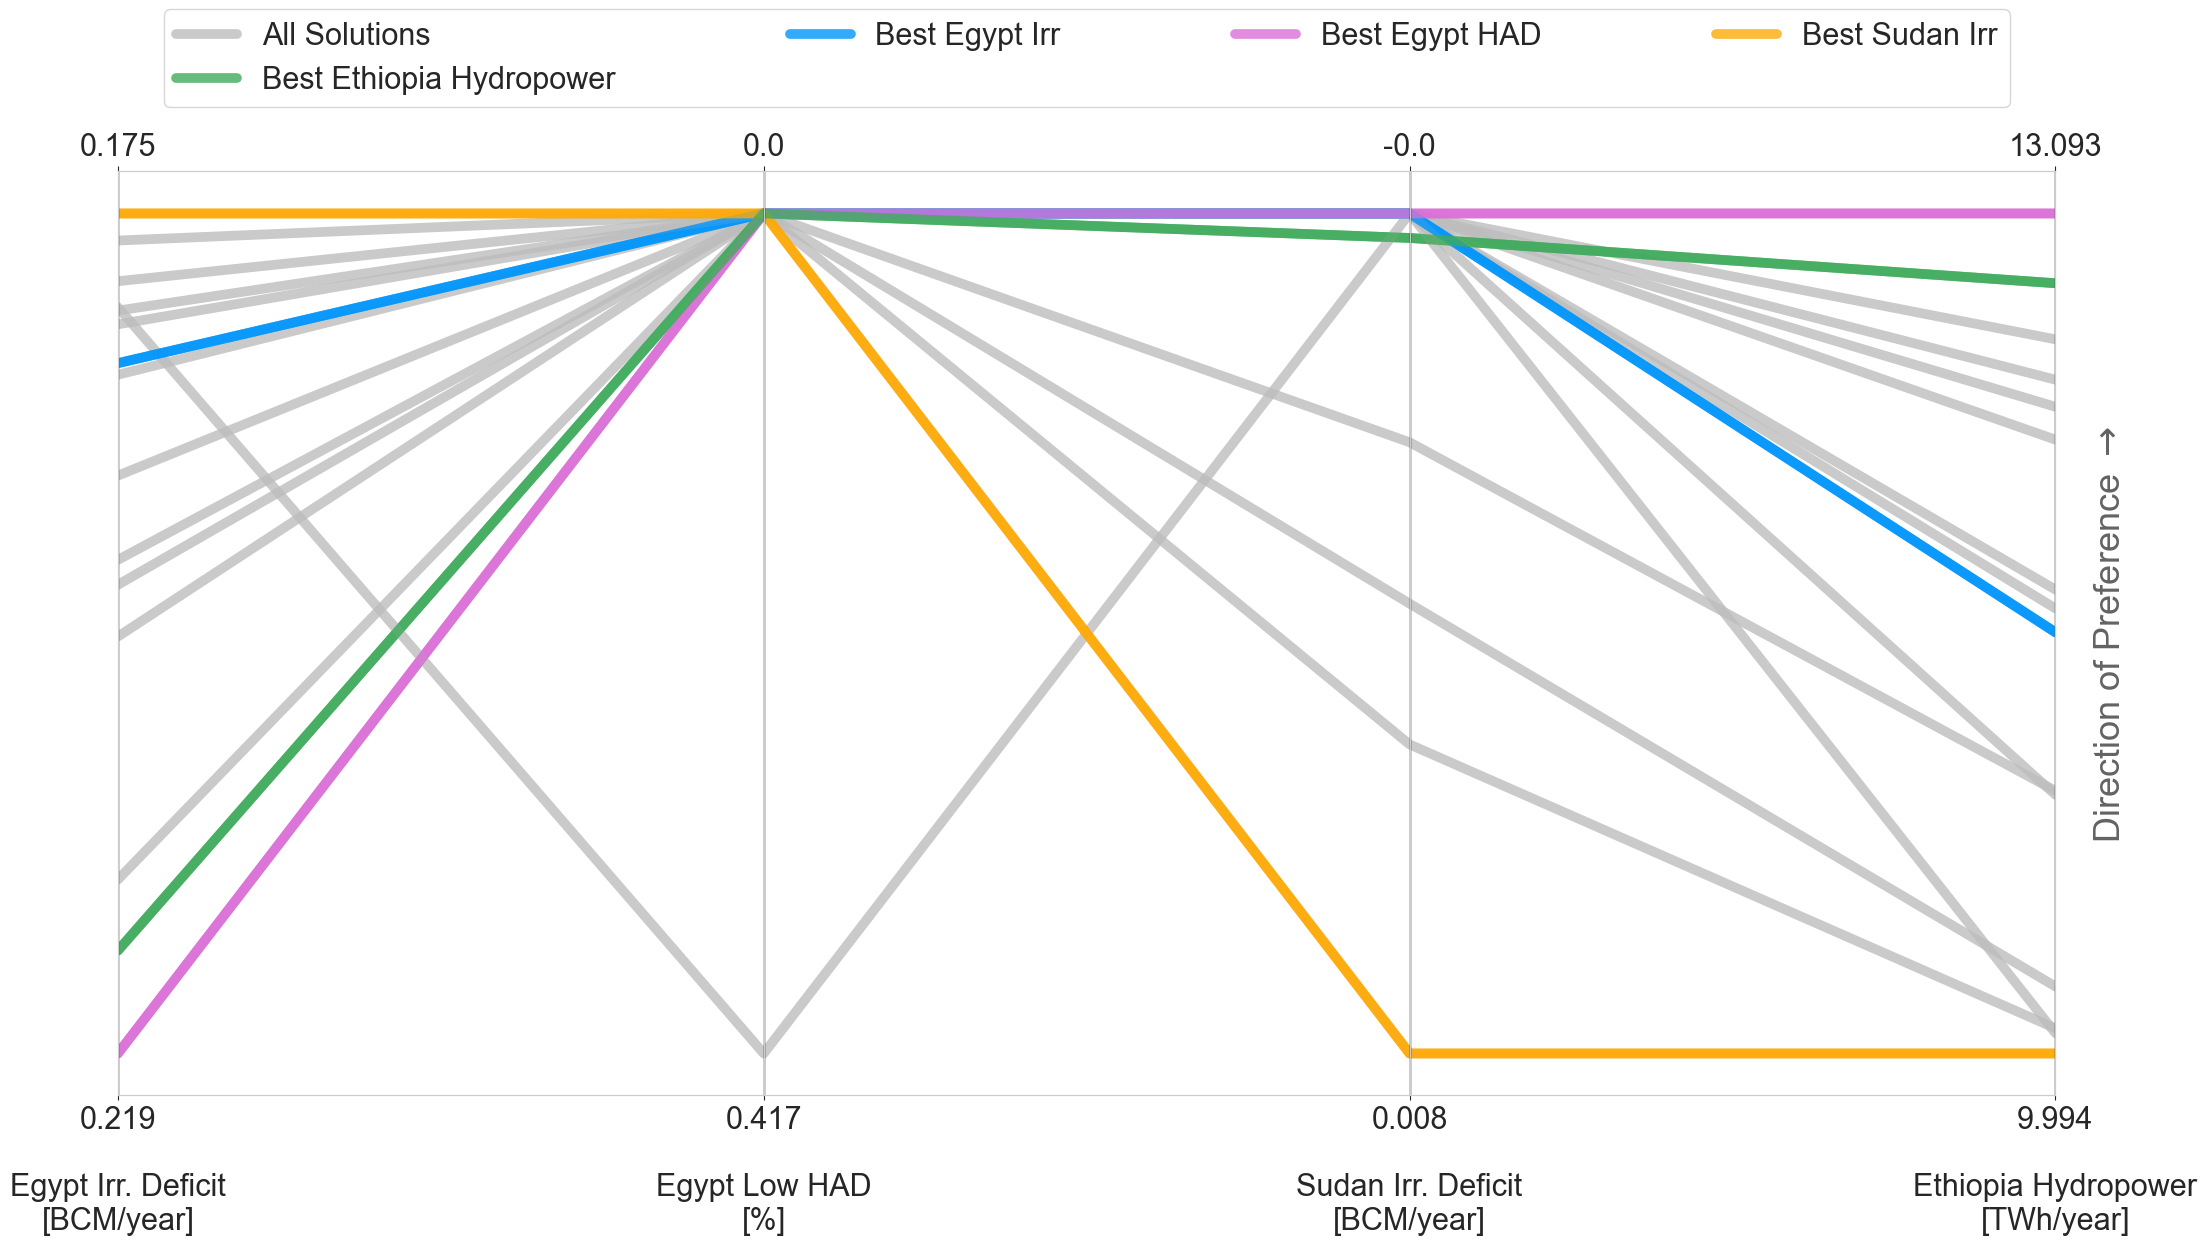

In [13]:
from plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    to_show,
    solution_indices=[10, 7, 14, 6],
    solution_names=[
        "Best Egypt Irr",
        "Best Egypt HAD",
        "Best Sudan Irr",
        "Best Ethiopia Hydropower",
    ],
)
plt.show()

In [14]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min":
            best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max":
            best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)

    return working_df, desirability_couples

In [15]:
def find_percentile_compromise_solutions(objectives_norm_df, percentile):
    # Given a threshold percentage and normalised objectives data frame,
    # returns the indices which performs above the threshold percentage
    # for all objectives
    index_lists = []
    for col in objectives_norm_df.columns:
        threshold = np.percentile(objectives_norm_df[col], percentile)
        index_lists.append(
            objectives_norm_df.loc[objectives_norm_df[col] >= threshold, :].index
        )

    common_indices = []
    for i in objectives_norm_df.index:
        counter = 0
        for check_list in index_lists:
            if i not in check_list:
                break
            counter += 1
        if counter == len(index_lists):
            common_indices.append(i)

    return common_indices

In [16]:
def find_threshold_compromise_solutions(objectives_norm_df, threshold):
    # Given a threshold value [0-1] and normalized objectives DataFrame,
    # returns the indices which perform above the threshold value
    # for all objectives
    
    # Initialize a set with all indices
    common_indices = set(objectives_norm_df.index)
    
    # Intersect the set with indices meeting the threshold for each column
    for col in objectives_norm_df.columns:
        above_threshold_indices = set(objectives_norm_df.loc[objectives_norm_df[col] >= threshold].index)
        common_indices.intersection_update(above_threshold_indices)
        
    return list(common_indices)

In [17]:
normalized, desire = normalize_objs(to_show, ["min", "min", "min", "max"])
print(normalized)

    egypt_irr  egypt_low_had  sudan_irr  ethiopia_hydro
0    0.207093            1.0   1.000000        0.850157
1    0.496328            1.0   1.000000        0.802130
2    0.557979            1.0   1.000000        0.769859
3    0.687909            1.0   1.000000        0.552229
4    0.867998            1.0   0.727625        0.312630
5    0.587623            1.0   1.000000        0.730717
6    0.122555            1.0   0.970864        0.916957
7   -0.000000            1.0   1.000000        1.000000
8    0.808004            1.0   1.000000        0.529754
9    0.888356           -0.0   1.000000        0.024105
10   0.821787            1.0   1.000000        0.501354
11   0.919348            1.0   0.535531        0.079737
12   0.967785            1.0   0.367917        0.029978
13   0.884406            1.0   1.000000        0.307959
14   1.000000            1.0  -0.000000        0.000000


In [18]:
print(find_percentile_compromise_solutions(normalized, 50))

[8]


In [19]:
print(find_threshold_compromise_solutions(normalized, 0.58))

[5]


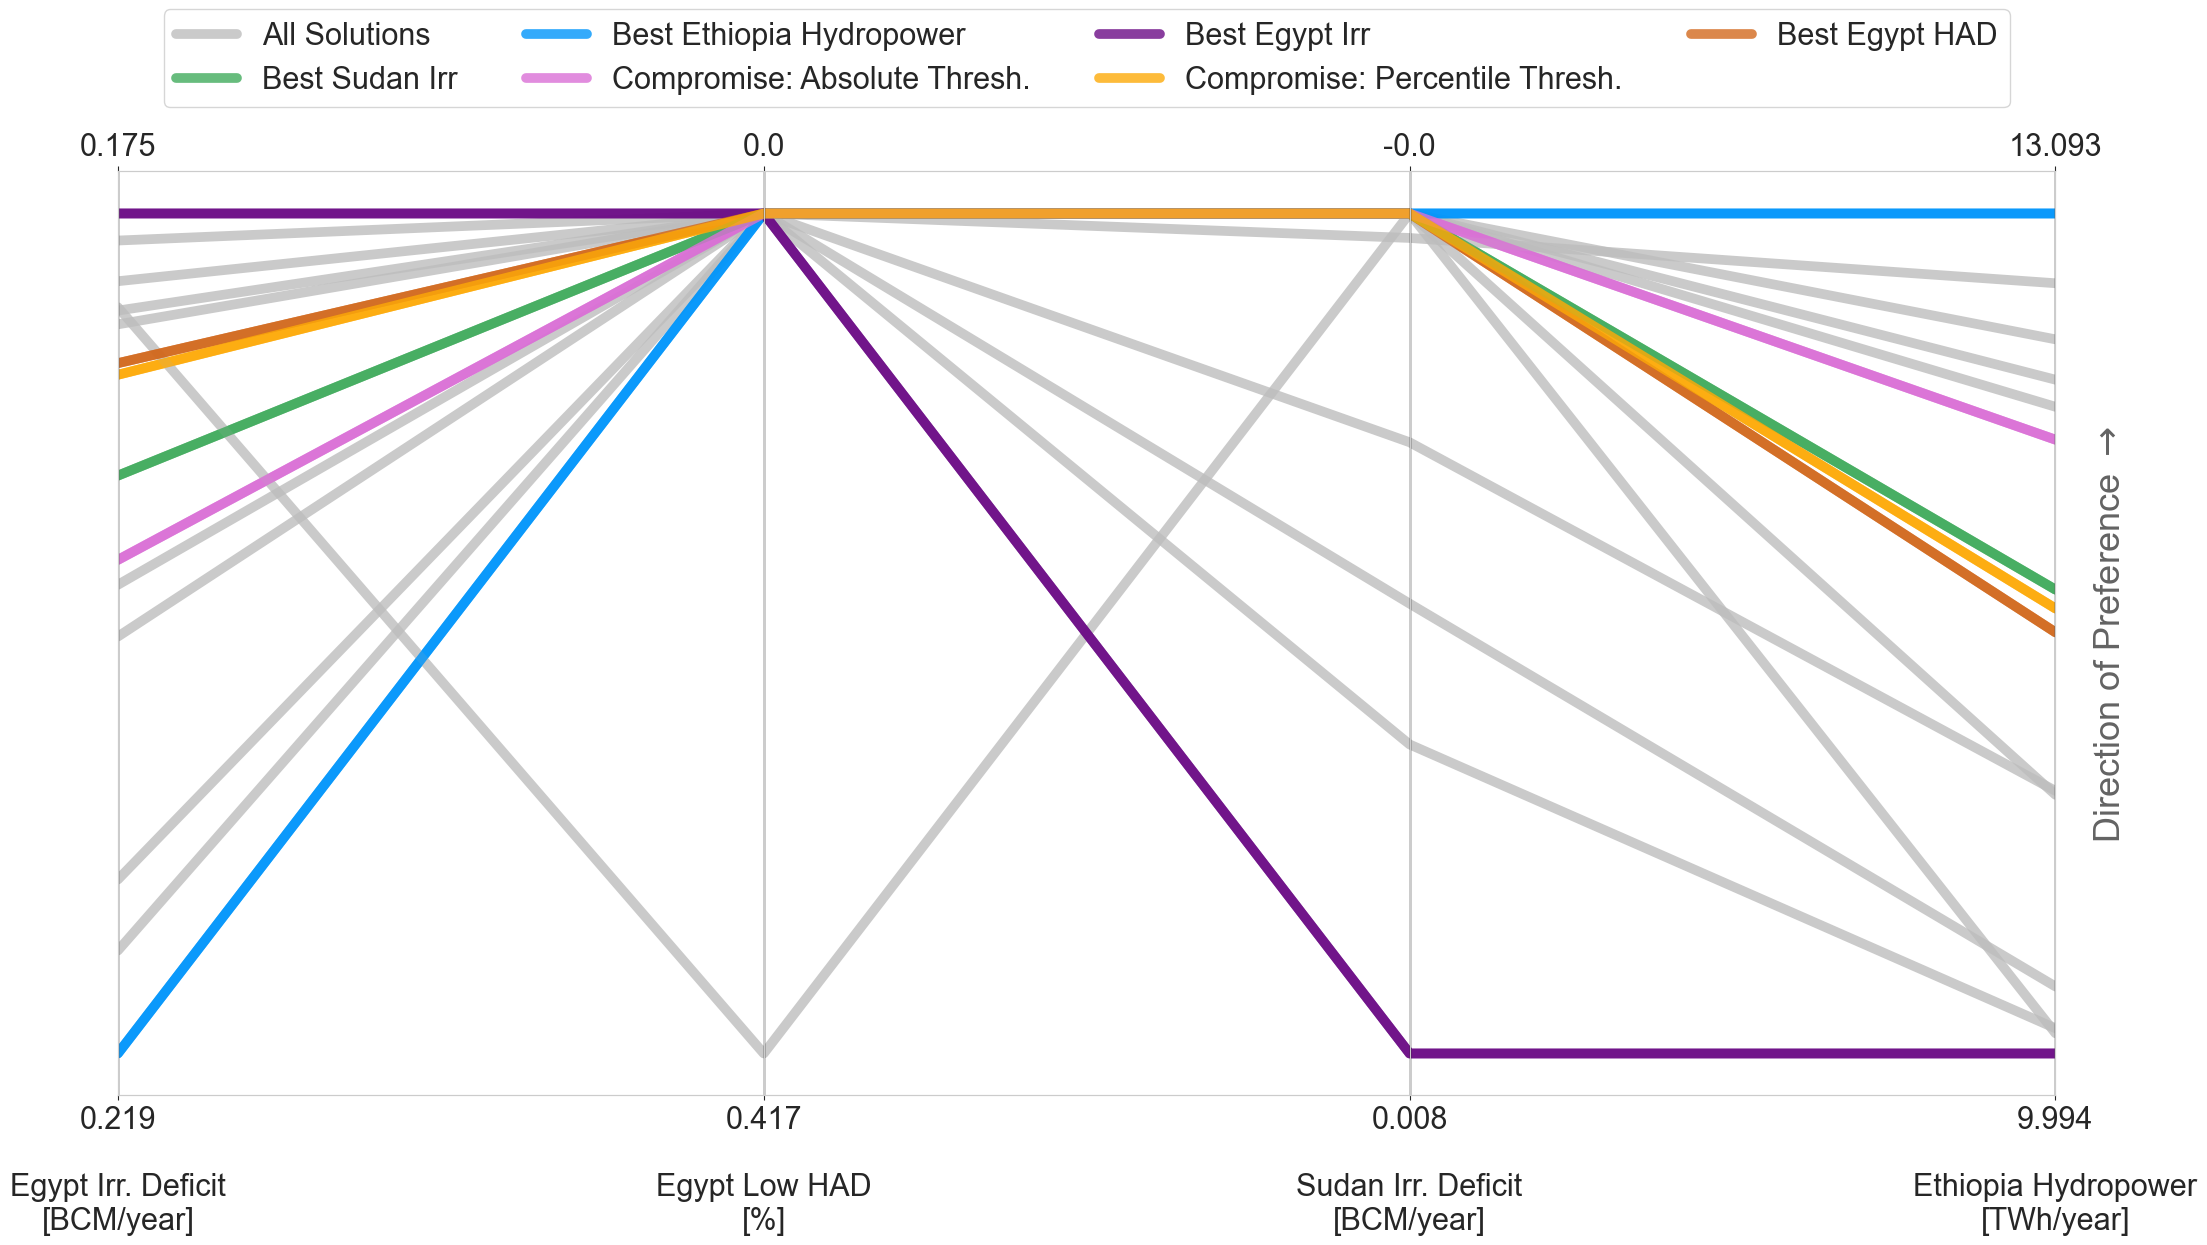

In [36]:
from plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    to_show,
    solution_indices=[7, 14, 10, 3, 5, 8],
    solution_names=[
        "Best Ethiopia Hydropower",
        "Best Egypt Irr",
        "Best Egypt HAD",
        "Best Sudan Irr",
        "Compromise: Absolute Thresh.",
        "Compromise: Percentile Thresh."
    ],
)
plt.savefig("parallel_plots.svg", bbox_inches="tight")
plt.show()

In [37]:
print(to_show.iloc[7])
print(to_show.iloc[5])
print(to_show.iloc[8])

egypt_irr          0.219467
egypt_low_had      0.000000
sudan_irr         -0.000000
ethiopia_hydro    13.092818
Name: 7, dtype: float32
egypt_irr          0.193391
egypt_low_had      0.000000
sudan_irr         -0.000000
ethiopia_hydro    12.258314
Name: 5, dtype: float32
egypt_irr          0.183611
egypt_low_had      0.000000
sudan_irr         -0.000000
ethiopia_hydro    11.635535
Name: 8, dtype: float32
